In [1]:
import pandas as pd
import pickle as pkl
from create_datasets.create_table_datasets import adni_data
from ml_models.machine_learning_models import create_class_ADNI, main, baseline_model
import seaborn as sns
import matplotlib.pyplot as plt

**1. Create table datasets**

Create table datasets (with and without APOE) for the targets and genes of interest to use as input for more-standard machine learning models.

In [2]:
diseases = ['AD']

infile1 = f'data/ADNI/AD_PPI_missense.csv'
infile2 = 'data/ADNI/ADNIMERGE_genetics_biomarkers.csv'

table_dataset = adni_data('missense', 'AD', infile1, infile2)
table_dataset.to_csv(f'data/table_datasets/AD_PPI_missense_with_biomarkers.csv')

In [2]:
targets = ['PET', 'PETandDX']

for target in targets:

    infile = f'data/table_datasets/AD_PPI_missense_with_biomarkers.csv'
    data = pd.read_csv(infile, index_col = 0)
    data_wclass = create_class_ADNI(data, target)

    x = data_wclass.drop(columns=['y'])
    x = x['APOE']

    y = data_wclass['y']
    x.index = x.index.str.upper()

    baseline_model(x, y)

    # f = open(f'data/splits/split_{target}.pkl', 'rb')
    # split_pet = pkl.load(f)
    # f.close()

    # auc_pet = baseline_model(split_pet, x, y)
    # print(f'Baseline model {target}, AUC ROC:', auc_pet)

Class distribution:
1.0    410
0.0    316
Name: y, dtype: int64
1
Acc. 0.636986301369863
Pre. 0.8133333333333334
Rec. 0.61
F1. 0.6971428571428571
AUC. 0.6971428571428571

2
Acc. 0.5724137931034483
Pre. 0.5590551181102362
Rec. 0.922077922077922
F1. 0.696078431372549
AUC. 0.696078431372549

3
Acc. 0.5172413793103449
Pre. 0.5234375
Rec. 0.881578947368421
F1. 0.6568627450980392
AUC. 0.6568627450980392

4
Acc. 0.6344827586206897
Pre. 0.7164179104477612
Rec. 0.5853658536585366
F1. 0.6442953020134228
AUC. 0.6442953020134228

5
Acc. 0.5448275862068965
Pre. 0.5365853658536586
Rec. 0.88
F1. 0.6666666666666667
AUC. 0.6666666666666667

0.6450680269213531 +- 0.04743780842377121
Class distribution:
1.0    182
0.0    135
Name: y, dtype: int64
1
Acc. 0.859375
Pre. 0.9166666666666666
Rec. 0.8461538461538461
F1. 0.8799999999999999
AUC. 0.8799999999999999

2
Acc. 0.671875
Pre. 0.7317073170731707
Rec. 0.75
F1. 0.7407407407407408
AUC. 0.7407407407407408

3
Acc. 0.6190476190476191
Pre. 0.6216216216216216
Re

**2. Run no-GNN models**

Run more-standard machine learning models 3 times (to properly compare with the 3 runs for each GNN model).

In [ ]:
targets = ['PET', 'PETandDX']

for target in targets:
    for i in range(1, 4):
        result_ad = main('ADNI', 'AD', 'PPI', target, 'data/table_datasets', f'results/results_missense_PET_rep{i}')
        result_ad_noAPOE = main('ADNI_noAPOE', 'AD', 'PPI', target, 'data/table_datasets', f'results/results_missense_PET_noAPOE_rep{i}')

Joint results of both baseline, no-GNN, and GNN models are in [results/GNNs_comparison](results/GNNs_comparison/) for [PET](results/GNNs_comparison/2022_01_PET.csv) and [PET&DX](results/GNNs_comparison/2022_01_PETandDX.csv) targets.

Next lines plot these results obtained using ADNI dataset (Figure 2 of the paper).

In [225]:
def statistics(df, baseline):
    pvalues = pd.DataFrame()
    for d in df['Dataset'].unique():
        tmp = df.loc[df['Dataset'] == d]
        for m in ['Random Forest', 'SVM Linear', 'SVM RBF', 'Logistic Regression', 'GNN GraphGym']:
            tmp_model = tmp.loc[tmp['Model'] == m]
            values = tmp_model['AUC'].values
            t1, p1 = stats.ttest_1samp(values, baseline, alternative='greater') # (a, popmean), mean of the underlying distribution of the sample is greater than the given population mean (popmean)
            t2, p2 = stats.ttest_1samp(values, 0.5, alternative='greater') # (a, popmean), mean of the underlying distribution of the sample is greater than the given population mean (popmean)
            
            if p1 < 0.05:
                s1 = '*'
            else:
                s1 = '-'

            if p2 < 0.05:
                s2 = '*'
            else:
                s2 = '-'

            # print(d, m, p1, p2)

            pvalues = pvalues.append([[d, m, p1, s1, p2, s2]])
            
    pvalues.rename(columns={0:'Dataset', 1:'Model', 2:'p-value Baseline', 3:'sigf. Baseline', 4:'p-value Random', 5:'sigf. Random'}, inplace=True)
    return pvalues
    

In [250]:
def barplot_comparision_ml(target, bs, df, metric, title):

    sns.set_style("ticks")
    
    colors = ["#F8766D", "#a3a500", "#00bf7d", "#00b0f6", "#E76BF3"]
    custom = sns.set_palette(sns.color_palette(colors))

    plt.figure(figsize=(8, 8))
    sns.barplot(x = 'Dataset',
                     y = metric,
                     hue = 'Model',
                     ci = 'sd',
                     data = df,
                     palette = custom)
    plt.axhline(y=bs, color='r', linestyle='dotted', label=f'Baseline model ({bs})')
    # plt.axhline(y=0.5, color='b', linestyle='dotted', label=f'Random (0.5)')

    plt.legend(fontsize=12, loc='upper center')
    plt.ylim(0.0, 1.0)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel(f'{metric} obtained in test set', fontsize=16)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    
    plt.savefig(f'figures/figure2{title}.pdf', dpi=500)
    plt.savefig(f'figures/figure2{title}.png', dpi=500)

In [251]:
from scipy import stats

pet_results = pd.read_csv('results/GNNs_comparison/2022_03_PET.csv')
pet_baseline = pet_results.iloc[30]
pet_results.drop([30], inplace=True)
pet_pvalues = statistics(pet_results, 0.6894)
pet_pvalues



,Dataset,Model,p-value Baseline,sigf. Baseline,p-value Random,sigf. Random
0,AD STRING,Random Forest,0.996157,-,0.000441,*
0,AD STRING,SVM Linear,0.998261,-,0.000033,*
0,AD STRING,SVM RBF,0.999040,-,0.000018,*
0,AD STRING,Logistic Regression,1.000000,-,0.000000,*
0,AD STRING,GNN GraphGym,0.094940,-,0.001528,*
0,AD STRING\nNo APOE,Random Forest,0.997838,-,0.945013,-
0,AD STRING\nNo APOE,SVM Linear,0.999207,-,0.041044,*
0,AD STRING\nNo APOE,SVM RBF,0.948836,-,0.663071,-
0,AD STRING\nNo APOE,Logistic Regression,0.998897,-,0.808384,-
0,AD STRING\nNo APOE,GNN GraphGym,0.990536,-,0.207235,-


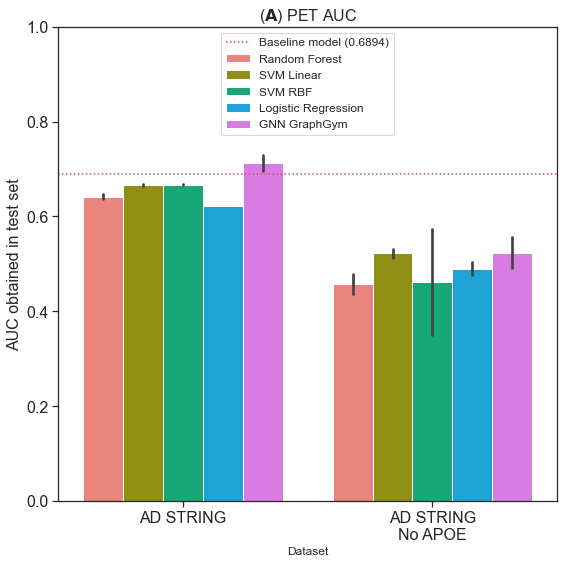

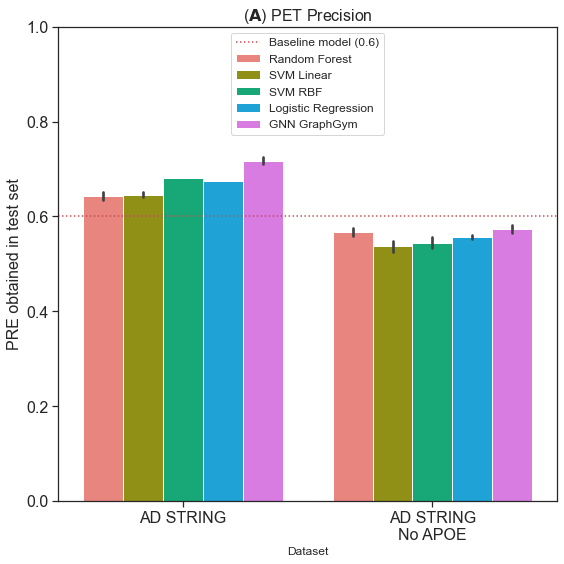

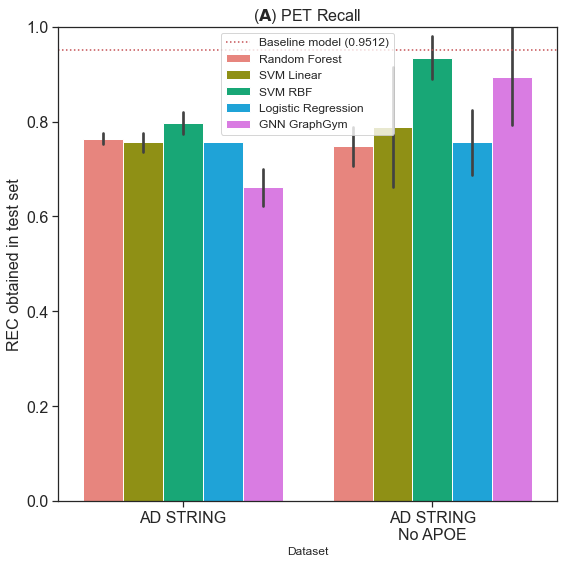

In [252]:
barplot_comparision_ml('PET', pet_baseline['AUC'], pet_results, 'AUC', r"($\bf{A}$) PET AUC")
barplot_comparision_ml('PET', pet_baseline['PRE'], pet_results, 'PRE', r"($\bf{A}$) PET Precision")
barplot_comparision_ml('PET', pet_baseline['REC'], pet_results, 'REC', r"($\bf{A}$) PET Recall")

In [253]:
petdx_results = pd.read_csv('results/GNNs_comparison/2022_03_PETandDX.csv')
petdx_baseline = petdx_results.iloc[30]
petdx_results.drop([30], inplace=True)
petdx_pvalues = statistics(petdx_results, 0.6825)
petdx_pvalues

,Dataset,Model,p-value Baseline,sigf. Baseline,p-value Random,sigf. Random
0,AD STRING,Random Forest,0.016356,*,0.000935,*
0,AD STRING,SVM Linear,0.998967,-,0.000037,*
0,AD STRING,SVM RBF,0.962577,-,0.000086,*
0,AD STRING,Logistic Regression,1.000000,-,0.000000,*
0,AD STRING,GNN GraphGym,0.099680,-,0.002236,*
0,AD STRING\nNo APOE,Random Forest,0.997332,-,0.049300,*
0,AD STRING\nNo APOE,SVM Linear,0.976788,-,0.746133,-
0,AD STRING\nNo APOE,SVM RBF,0.978437,-,0.719308,-
0,AD STRING\nNo APOE,Logistic Regression,0.998343,-,0.908248,-
0,AD STRING\nNo APOE,GNN GraphGym,0.942137,-,0.371337,-


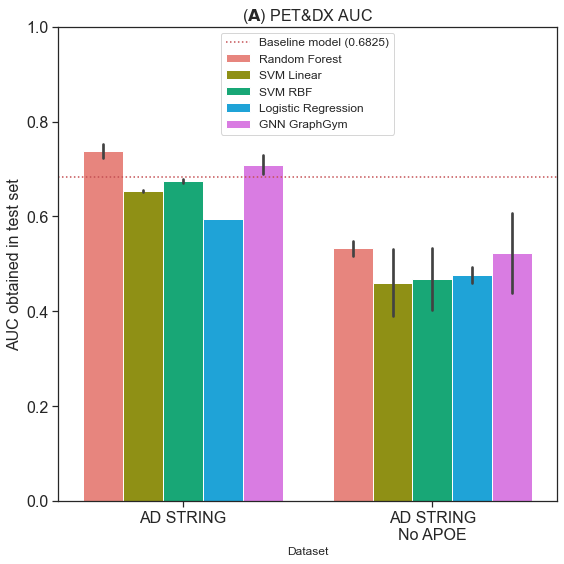

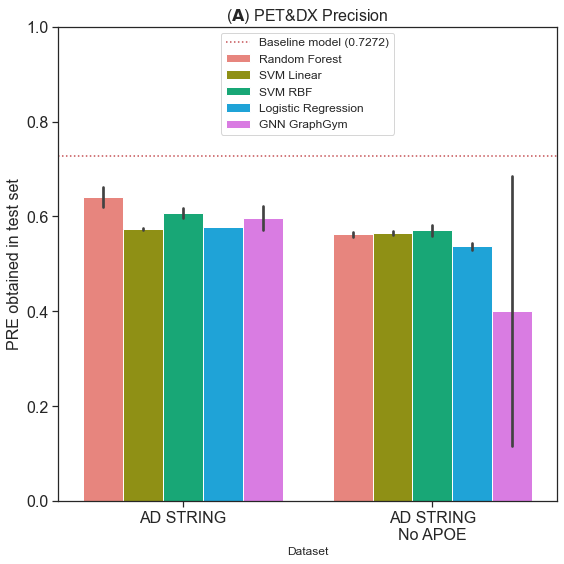

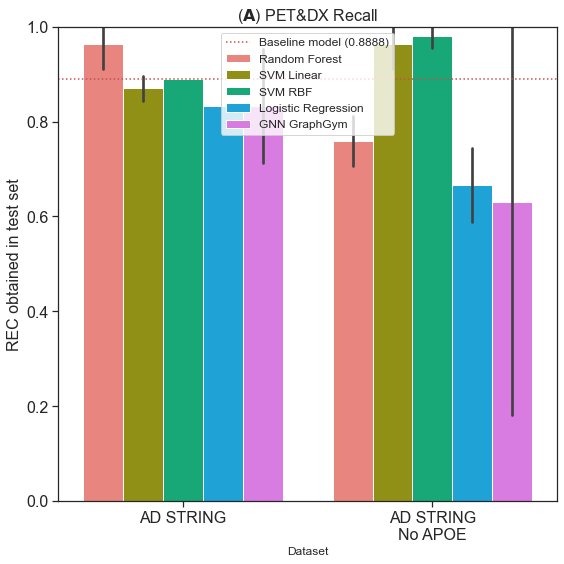

In [254]:
barplot_comparision_ml('PET&DX', petdx_baseline['AUC'], petdx_results, 'AUC', r"($\bf{A}$) PET&DX AUC")
barplot_comparision_ml('PET&DX', petdx_baseline['PRE'], petdx_results, 'PRE', r"($\bf{A}$) PET&DX Precision")
barplot_comparision_ml('PET&DX', petdx_baseline['REC'], petdx_results, 'REC', r"($\bf{A}$) PET&DX Recall")